# Folding/Unfolding procedure demonstration

This Notebook is meant to demonstrate the processes of Folding/Unfolding that convert multi channel 1D arrays into 2D images, suitable for Semantic Segmentation Models.

## Import Dependencies

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import tensor

### Add utils to sys to import our custom scripts
**Note:** This notebook should be run from the `examples` folder to ensure the correct imports and file paths are used.

In [2]:
# Go up one level from 'examples' and point to 'utils' folder
utils_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'utils'))
# Add the 'utils' folder to sys.path
sys.path.append(utils_path)
import data_utils

### Example data paths

In [3]:
example_data = {"VT": "../data/example_VT.npy",
                 "LP": "../data/example_LP.npy",
                 "TR": "../data/example_TR.npy",
                 "AV": "../data/example_AV.npy",
                 "IC": "../data/example_IC.npy",
                 }

### Example plot

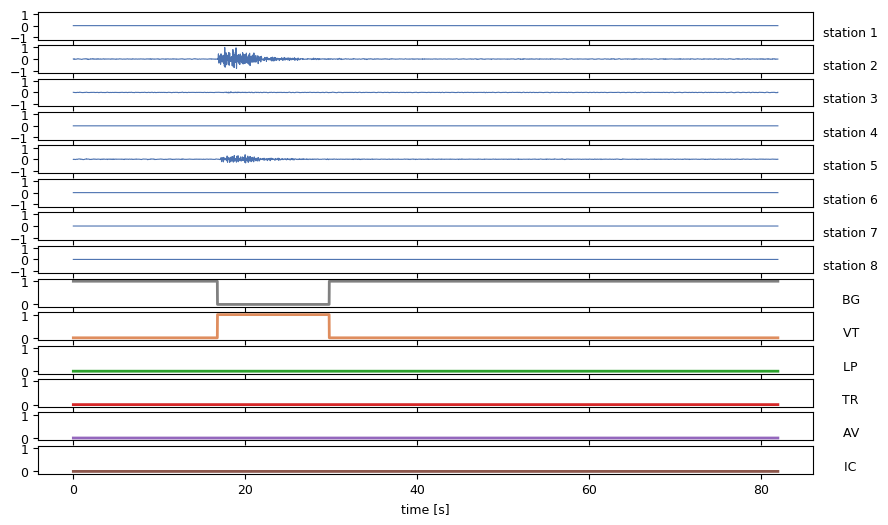

In [4]:
example_trace = np.load(example_data['VT'])
data_utils.print_trace(example_trace,
                        n_stations=8,
                        save_path=None,
                        save=False,
                        title="",
                        num=0,
                        dpi=100,
                        figsize=(10, 6),
                        font_size=9)

## Folding

### Multi-channel 1D signals
Our input starts as an 8x8192 array, which represents 8 stations sampled at 100Hz for a window of 81.92 seconds. The specifity of this duration is explained in the article and stems from the need to produce a 2D representation NxN so that $N=256=\sqrt{8\times 8192}$.

In [5]:
input_signal = example_trace[:8,:]
print(input_signal.shape)

(8, 8192)


We can visualize the array by expanding the y-axis (size 8) and compressing the x-axis (size 8192). This allows comparison to the plotted signals in the previous cells.

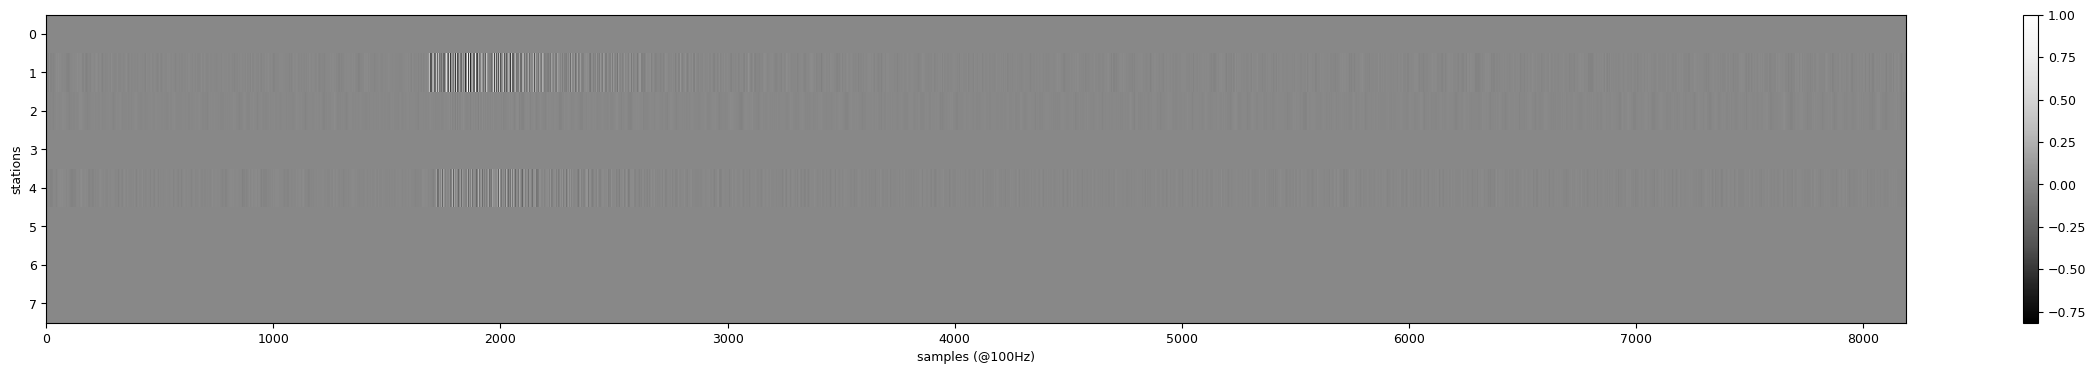

In [6]:
plt.figure(figsize=(30,4))
plt.imshow(input_signal,aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("stations")
plt.colorbar()
plt.show()

### Folding of the input

To perform Folding, we use PyTorch functions:

torch.Size([1, 256, 256])


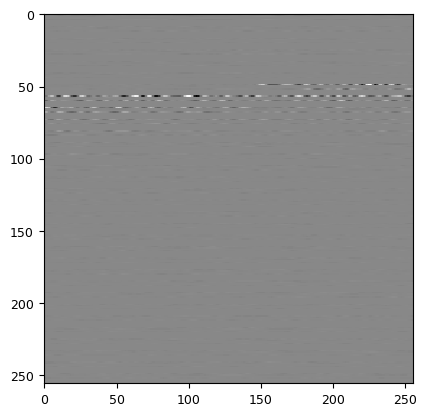

In [7]:
input_tensor = tensor(input_signal)
folded_input = data_utils.fold_X(input_tensor, N=256)
print(folded_input.shape)
plt.imshow(folded_input[0].numpy(), cmap='Greys_r', interpolation='nearest')
plt.show()

### Target Generation

We have 6 1D arrays indicating the presence of the event in time:

In [8]:
output_labels = example_trace[8:,:]
print(output_labels.shape)

(6, 8192)


We can see a compressed representation of the target arrays. Notice that the Background class (0) is 1 when there is no event, and 0 when an event appears. The corresponding class (in this case, 3) is set to 1 during the event's duration. The rest remain 0.

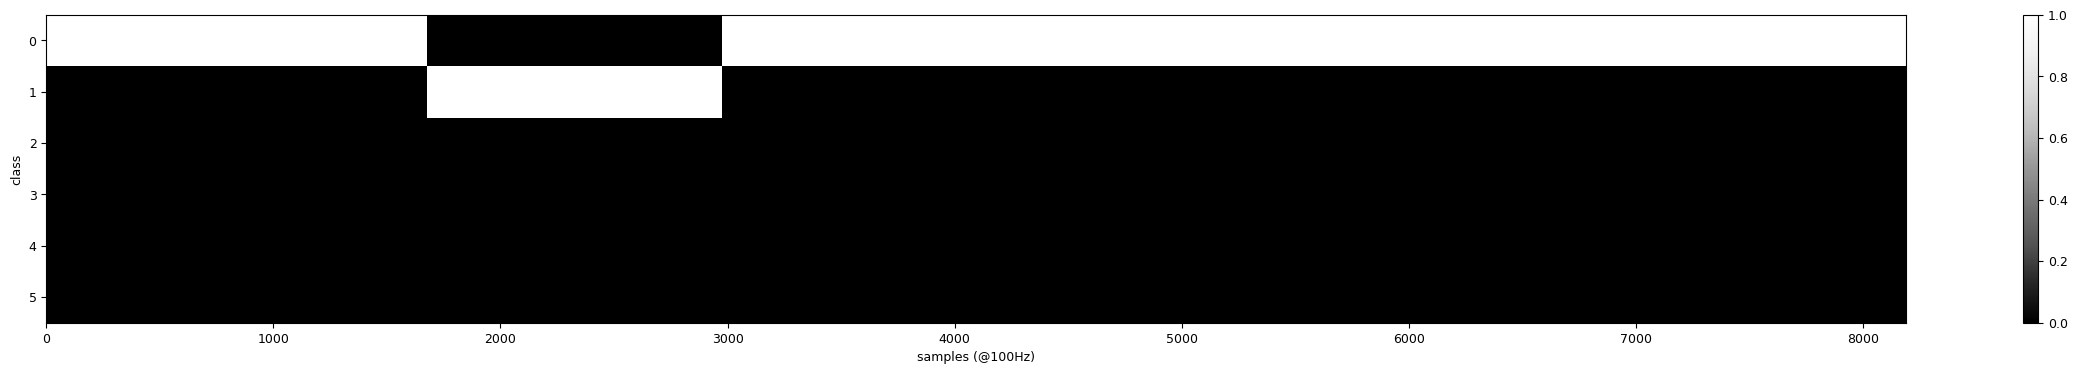

In [9]:
plt.figure(figsize=(30,4))
plt.imshow(output_labels,aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("class")
plt.colorbar()
plt.show()

### Folding of the target

To train our models we require 2D targets, this is again obtained through folding. The main difference here is that we generate 6 masks (one per class) and that we have to repeat our 1D label through the 8 stations.

In [10]:
output_tensor = tensor(output_labels)
print("before repetition", output_tensor.shape)
repeated_tensor = output_tensor.unsqueeze(1).repeat(1, 8, 1) # repetition of the labeles accross the 8 stations
print("after repetition", repeated_tensor.shape)

before repetition torch.Size([6, 8192])
after repetition torch.Size([6, 8, 8192])


For example, the label tensor for class 3 results in:

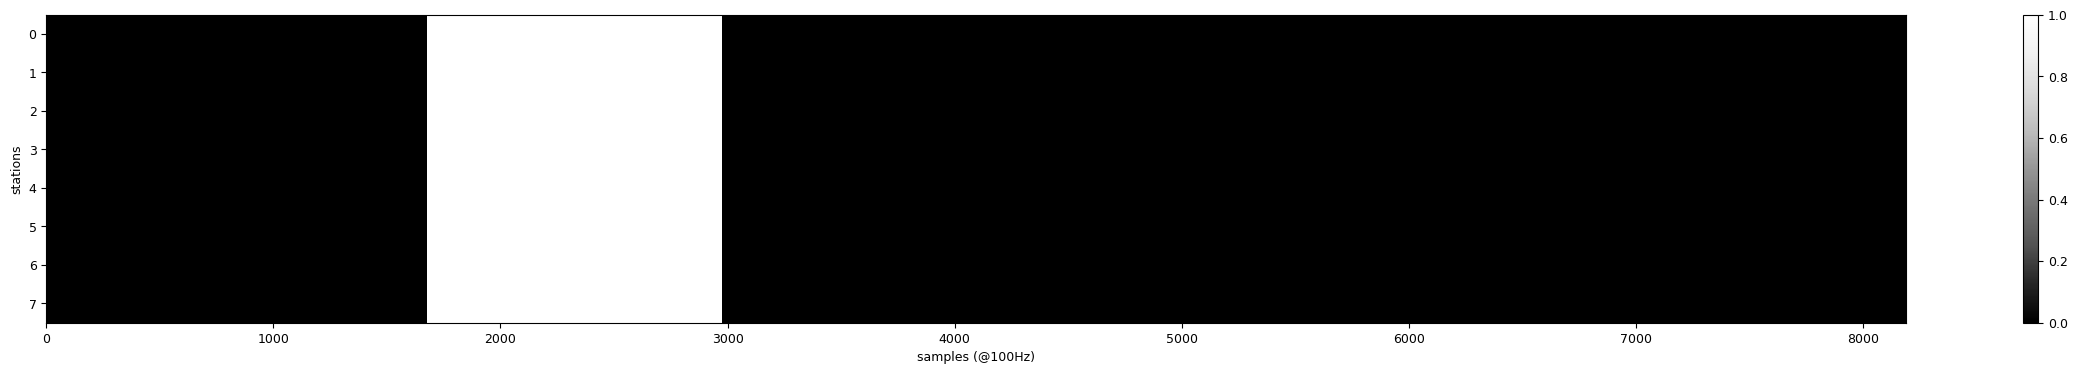

In [11]:
plt.figure(figsize=(30,4))
plt.imshow(repeated_tensor[1].numpy(),aspect="auto", cmap="Greys_r", interpolation="nearest")
plt.xlabel("samples (@100Hz)")
plt.ylabel("stations")
plt.colorbar()
plt.show()

We fold every array to obtain a 2D mask for each class, that the model has to learn:

**Note**: The function fold_y() performs the repeat procedure along the 8 stations.

In [12]:
folded_targets = data_utils.fold_y(output_tensor)
print(folded_targets.shape)

torch.Size([6, 256, 256])


We train the models using six 2D masks for each event:

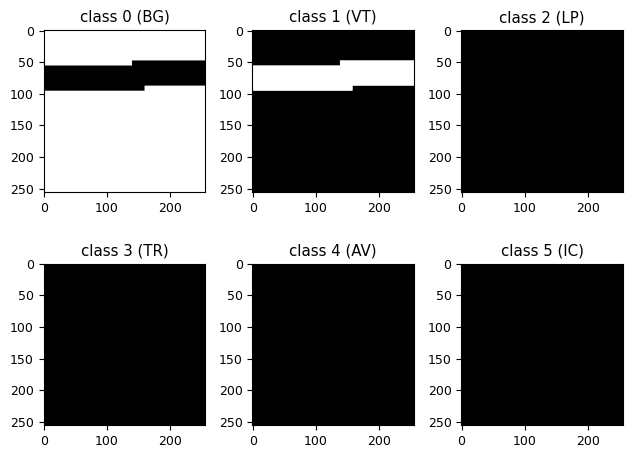

In [13]:
fig,axes = plt.subplots(2,3)
axes[0,0].imshow(folded_targets[0].numpy(),cmap='Greys_r')
axes[0,0].set_title('class 0 (BG)')
axes[0,1].imshow(folded_targets[1].numpy(),cmap='Greys_r')
axes[0,1].set_title('class 1 (VT)')
axes[0,2].imshow(folded_targets[2].numpy(),cmap='Greys_r')
axes[0,2].set_title('class 2 (LP)')
axes[1,0].imshow(folded_targets[3].numpy(),cmap='Greys_r')
axes[1,0].set_title('class 3 (TR)')
axes[1,1].imshow(folded_targets[4].numpy(),cmap='Greys_r')
axes[1,1].set_title('class 4 (AV)')
axes[1,2].imshow(folded_targets[5].numpy(),cmap='Greys_r')
axes[1,2].set_title('class 5 (IC)')
plt.tight_layout()
plt.show()